# Style transfer

In [1]:
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage

In [3]:
torch.backends.cudnn.benchmark = True

## Data

In [4]:
PATH = Path('data/imagenet/')

In [5]:
 TRN_PATH = PATH/'train'

In [6]:
img_filename = TRN_PATH/'n01558993'/'n01558993_9684.JPEG'

In [7]:
img = open_image(img_filename)

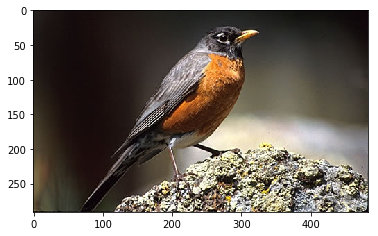

In [8]:
plt.imshow(img)

In [9]:
model = vgg16(pre=True).cuda().eval()

In [10]:
set_trainable(model, False)

In [11]:
sz = 228

In [12]:
train_tfms, val_tfms = tfms_from_model(vgg16, sz)

In [13]:
transformed_img = val_tfms(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


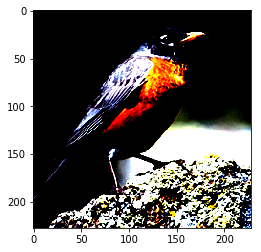

In [14]:
plt.imshow(transformed_img.transpose(1,2,0))

In [15]:
transformed_img.shape

(3, 228, 228)

## Create a random image

In [16]:
start_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)

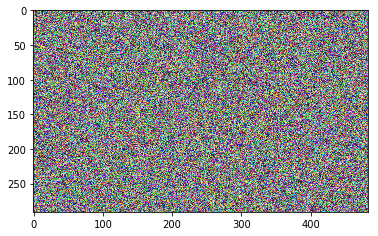

In [17]:
plt.imshow(start_img)

Hint: training starts much better if the picture is blurred/more even looking

In [18]:
start_img = scipy.ndimage.filters.median_filter(start_img, [8, 8, 1])

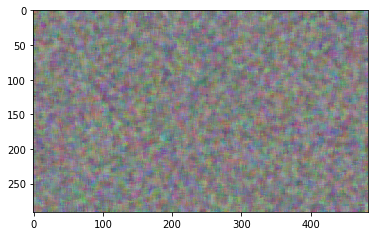

In [19]:
plt.imshow(start_img)

**We convert this starting image to a variable that *requires gradients*!**

In [20]:
start_img = val_tfms(start_img)/2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


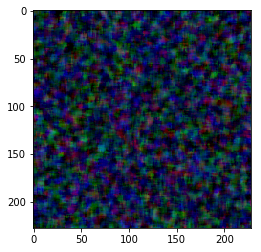

In [21]:
plt.imshow(start_img.transpose(1,2,0))

In [22]:
start_img_var = V(start_img[None], requires_grad=True)

In [23]:
start_img_var.shape

torch.Size([1, 3, 228, 228])

**Content loss: returns a lower number if the picture looks more like the bird. We use a 'perceptual loss' which means that instead of comparing the pixel values of the generated image to the bird image (which would give an exact copy of the bird), we calculate the loss from specific (arbitrarily chosen) activations in a later layer of a neural network. If two pictures cause 'similar activations' they should look similar while not being the same.**

**Let's grab an activation from a later layer:**

In [24]:
model = nn.Sequential(*list(model.children())[:37])

**Let's calculate the target activations of our bird image. Gradients not required!**

In [25]:
targ_act = model(V(transformed_img[None], requires_grad=False))  # slicing with None creates a unit axis <=> bs=1

In [26]:
targ_act.shape

torch.Size([1, 512, 14, 14])

**Loss function:**

In [27]:
def content_loss(x):
    return F.mse_loss(model(x), targ_act) * 1000

**Optimizer: LBFGS approximates the Hessian. 'L' stands for limited, only keeps track of certain number of gradients for the sake of memory.**

In [28]:
optimizer = optim.LBFGS([start_img_var], lr=0.5)  # pass a list of variables that require gradients

In [29]:
n_iter = 0

In [30]:
def step(loss_func):
    global n_iter
    optimizer.zero_grad()
    loss = loss_func(start_img_var)
    loss.backward()
    n_iter += 1
    if n_iter % 100 == 0: print(f'Iteration: {n_iter}, loss {loss.data[0]}')
    return loss

```
Arguments of THIS optimizer.step:
    closure (callable): A closure that reevaluates the model
        and returns the loss.
```

In [31]:
while n_iter < 1000:
    optimizer.step(partial(step, content_loss))

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 100, loss 0.8743968605995178
Iteration: 200, loss 0.3899644613265991
Iteration: 300, loss 0.2597558796405792
Iteration: 400, loss 0.20059503614902496
Iteration: 500, loss 0.16702961921691895
Iteration: 600, loss 0.1457725316286087
Iteration: 700, loss 0.13100214302539825
Iteration: 800, loss 0.119223952293396
Iteration: 900, loss 0.11056926101446152
Iteration: 1000, loss 0.10395707190036774


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


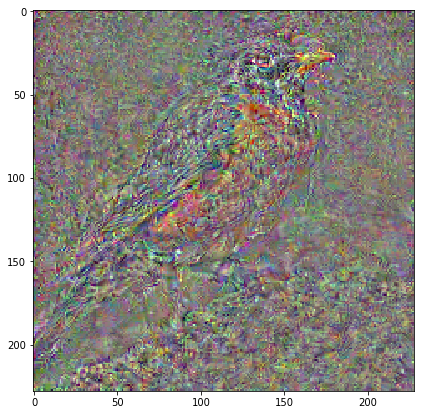

In [32]:
plt.figure(figsize=(7,7))
plt.imshow(val_tfms.denorm(start_img_var.data.cpu().numpy()[0].transpose(1,2,0)))

**Until now we simply took the activations from an arbitrarily chosen layer. It makes sense to assume that the result will improve if we compare the activations of specific layer (chosen through experimentation) or even of several layers. Pytorch offers a very convenient way of accessing them called 'forward hook'. Let's you grab whatever you want in the forward pass. 'Backward hooks' let you do the same for the backward pass.**

In [47]:
class SaveFeatures():
    features = None
    def __init__(self, model):
        self.hook = model.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True).cuda()
    def close(self):
        self.hook.remove()

In [48]:
model = vgg16(pre=True).cuda().eval()

In [49]:
set_trainable(model, False)

```
def set_trainable_attr(m,b):
    m.trainable=b
    for p in m.parameters(): p.requires_grad=b
```

In [50]:
block_ends = [i - 1 for i, o in enumerate(list(model.children())) if isinstance(o, nn.MaxPool2d)]
# grabs indices of all layers before MaxPool

In [51]:
block_ends

[5, 12, 22, 32, 42]

In [52]:
feat = SaveFeatures(list(model.children())[block_ends[3]])

In [53]:
def get_start():
    start_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    start_img = scipy.ndimage.filters.median_filter(start_img, [8, 8, 1])
    start_img_var = V(val_tfms(start_img / 2)[None], requires_grad=True)
    return start_img_var, optim.LBFGS([start_img_var])

In [54]:
start_img_var, optimizer = get_start()

In [55]:
all_targ_act = model(V(transformed_img[None], requires_grad=False))  # Next we get the activations from the hook

In [56]:
targ_act = V(feat.features.clone())

In [57]:
targ_act.shape

torch.Size([1, 512, 28, 28])

In [58]:
def content_loss2(x):
    model(x)
    output = feat.features  # last time we just used model(x) without the hook
    return F.mse_loss(output, targ_act) * 1000

In [59]:
n_iter = 0

In [60]:
while n_iter < 1000:
    optimizer.step(partial(step, content_loss2))

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 100, loss 0.2302749752998352
Iteration: 200, loss 0.09762980788946152
Iteration: 300, loss 0.06339003890752792
Iteration: 400, loss 0.04776123911142349
Iteration: 500, loss 0.03854565694928169
Iteration: 600, loss 0.03257789462804794
Iteration: 700, loss 0.028585441410541534
Iteration: 800, loss 0.025624124333262444
Iteration: 900, loss 0.02336995303630829
Iteration: 1000, loss 0.0215294286608696


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


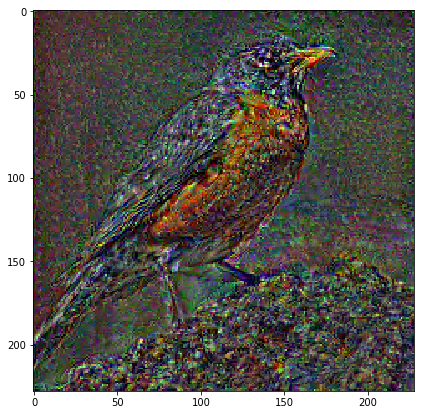

In [61]:
plt.figure(figsize=(7,7))
plt.imshow(val_tfms.denorm(start_img_var.data.cpu().numpy()[0].transpose(1,2,0)))

### Style loss: returns a lower number if the picture is closer to Van Gogh's style